# ICR - Identifying Age-Related Conditions

The objective of this notebook is to create a model to predict whether a person has none (Class 0) or any of three medical conditions (Class 1).
We are going to try to solve the problem by building a Random Forest model using TensorFlow Decision Forests on our dataset ICR - Identifying Age-Related Conditions, which is described as follows:

## Dataset Description

- `train.csv`: The training set.
  - `Id`: Unique identifier for each observation.
  - `AB-GL`: Fifty-six anonymized health characteristics. All are numeric except for `EJ`, which is categorical.
  - `Class`: A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

- `test.csv`: The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.

- `greeks.csv`: Supplemental metadata, only available for the training set.
  - `Alpha`: Identifies the type of age-related condition, if present.
  - `A`: No age-related condition. Corresponds to class 0.
  - `B`, `D`, `G`: The three age-related conditions. Correspond to class 1.
  - `Beta`, `Gamma`, `Delta`: Three experimental characteristics.
  - `Epsilon`: The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.


## Import the libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


## Load the Dataset

In [3]:
train_data = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
train_data.shape

(617, 58)

In [4]:
train_data

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


The data is composed of 58 columns and 617 entries. `Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`). Given the features of the dataset, the goal of our model is to predict the value of Class for any person.

## Dataset exploration

In [5]:
train_data.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


### Checking the balance in the classes.
We count the occurrences of each class in our dataset.

<Axes: ylabel='Class'>

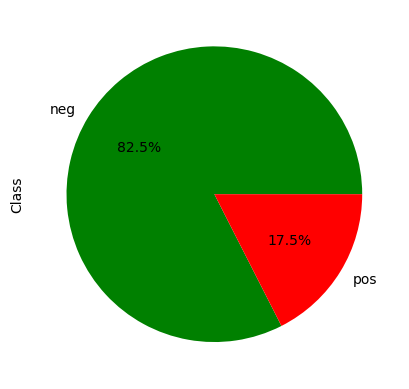

In [6]:
train_data['Class'].value_counts().plot(kind='pie', labels = ['neg', 'pos'], colors=['green', 'red'], autopct='%1.1f%%')

In [7]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(train_data['Class']) 

#Total samples 
total = neg + pos

#Percent of each class
per_neg = round((neg/total)*100,1)
per_pos = round((pos/total)*100,1)

print(f'Class 0: {per_neg} %')
print(f'Class 1: {per_pos} %')

Class 0: 82.5 %
Class 1: 17.5 %


**Important**: Based on the pie chart and the percentage distribution of each class in the dataset, it is evident that the dataset suffers from a significant class imbalance. The fraction of positive (`1`) samples is considerably smaller compared to the negative (`0`) samples.

## Analyzing the numerical data.
First, we will list all the numerical columns names.

In [8]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS =  [i for i in train_data.columns if i not in ["Id", "EJ", "Class"]]

Let us now plot the first 6 numerical columns and their values using bar charts.

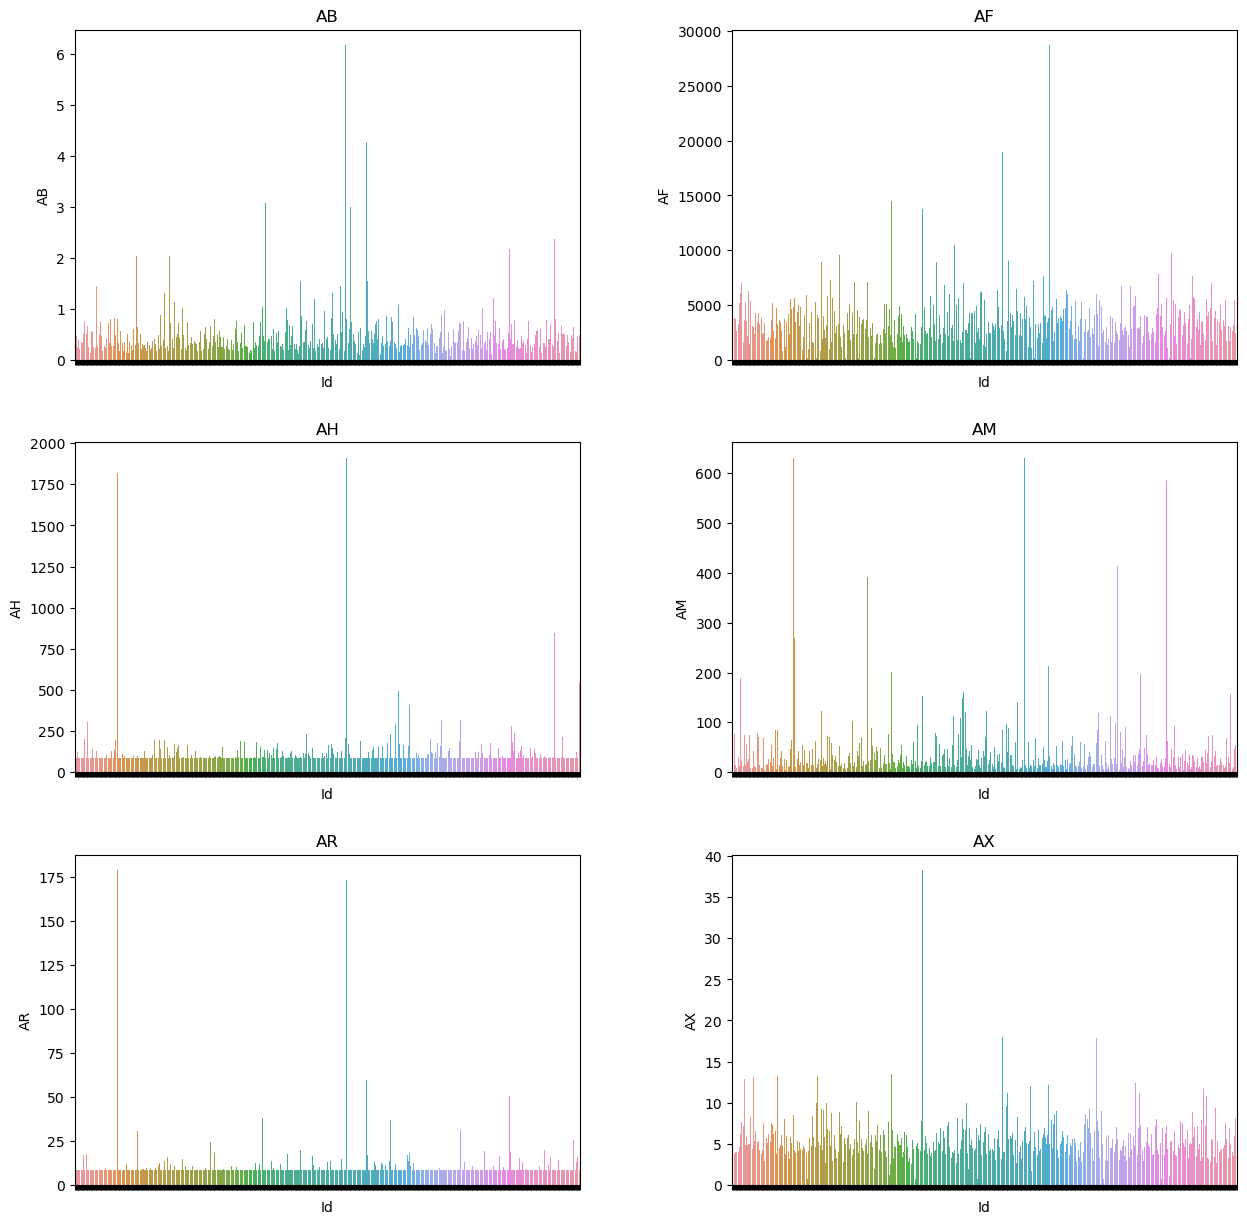

In [9]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=train_data['Id'], y=train_data[column_name])
    bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

We can observe that there are spikes in the values of certain features only for certain patients, which could indicate outliers in the data.

We will also create a list of feature columns that will be used for training. We will drop Id from the list since it is not needed.

In [10]:
FEATURE_COLUMNS = [i for i in train_data.columns if i not in ["Id"]]

Now let us split the dataset into training and testing datasets:

### KFold validation

Given the limited amount of data available, utilizing K-Fold cross-validation to train our model is a viable option to obtain effective results in the model's scoring.

We will split the dataset into 5 consecutive folds. Each fold is then used once as a validation set while the 4 (5-1) remaining folds form the training set.

In [11]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

### Out of Fold (OOF)

During K-Fold cross-validation, the predictions made on the test set of each fold are referred to as Out-of-Fold (OOF) predictions. We will assess the model's performance by aggregating the predictions made across all K (5 in this example) folds.

In our training loop, we will create a pandas dataframe named "oof" to store the predictions of the validation set during each fold.

In [12]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = train_data.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

## Strategies to handle the dataset imbalance

As mentioned earlier, positive samples account for only about 17% of our entire dataset. This means that our dataset is heavily imbalanced, which can lead to poor predictions by our model.

To address this class imbalance, we will use a strategy called "class weighting."

### Class weighting

Since the postive(`1`) Class labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing Keras weights for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. 

In [13]:
# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


## Train Random Forest model

As mentioned at the beginning of this notebook, we will create a Random Forest model to make our predictions.

Because of the smaller size of the dataset, it is likely that the model will overfit during training. Numerous parameters, primarily `max_depth` and `num_trees` can be changed to fine-tune the model and prevent overfitting.

The attribute `max_depth` indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is `16`. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter `num_trees` from its default value(`300`). In our model we are using `max_depth = 6`, and `num_trees = 550`.

We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [14]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=train_data)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = train_data.iloc[train_index]
        valid_df = train_data.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[FEATURE_COLUMNS]
        valid_df = valid_df[FEATURE_COLUMNS]
        
        # There's one more step required before we can train the model. 
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library 
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        # Note: Some column names contains white spaces at the end of their name, 
        # which is non-comaptible with SavedModels save format. 
        # By default, `pd_dataframe_to_tf_dataset` function will convert 
        # this column names into a compatible format. 
        # So you can safely ignore the warnings related to this.
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel(max_depth=6, num_trees=550)
        rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
        
        # Train the model
        # We will train the model using a one-liner.
        # Note: you may see a warning about Autograph. 
        # You can safely ignore this, it will be fixed in the next release.
        # Previously calculated class weights is used to handle imbalance.
        rf.fit(x=train_ds, class_weight=class_weight)
        
        # Store the model
        models[f"fold_{i+1}"] = rf
        
        
        # Predict OOF value for validation data
        predict = rf.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        oof.loc[valid_ids, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Use /tmp/tmpxnlb0nl4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.455621. Found 493 examples.
Training model...
Model trained in 0:00:00.251381
Compiling model...


[INFO 23-07-04 03:16:32.6396 UTC kernel.cc:1242] Loading model from path /tmp/tmpxnlb0nl4/model/ with prefix 4e4c9c1323104590
[INFO 23-07-04 03:16:32.6704 UTC decision_forest.cc:660] Model loaded with 550 root(s), 17894 node(s), and 56 input feature(s).
[INFO 23-07-04 03:16:32.6704 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-04 03:16:32.6704 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 532ms/step - loss: 0.0000e+00 - accuracy: 0.9677 - binary_crossentropy: 0.2300
##### Fold 2
Use /tmp/tmpq86voi85 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.700582. Found 493 examples.
Training model...
Model trained in 0:00:00.207249
Compiling model...


[INFO 23-07-04 03:16:36.4415 UTC kernel.cc:1242] Loading model from path /tmp/tmpq86voi85/model/ with prefix 4dd7e09dbc404ce4
[INFO 23-07-04 03:16:36.4685 UTC decision_forest.cc:660] Model loaded with 550 root(s), 18114 node(s), and 56 input feature(s).
[INFO 23-07-04 03:16:36.4687 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2759
##### Fold 3
Use /tmp/tmpo0j3mfxd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.700287. Found 494 examples.
Training model...
Model trained in 0:00:00.203281
Compiling model...


[INFO 23-07-04 03:16:38.2617 UTC kernel.cc:1242] Loading model from path /tmp/tmpo0j3mfxd/model/ with prefix 460c04beb9104133
[INFO 23-07-04 03:16:38.2886 UTC decision_forest.cc:660] Model loaded with 550 root(s), 17492 node(s), and 56 input feature(s).
[INFO 23-07-04 03:16:38.2887 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - accuracy: 0.9106 - binary_crossentropy: 0.2910
##### Fold 4
Use /tmp/tmpqjs80nwq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.703633. Found 494 examples.
Training model...
Model trained in 0:00:00.209231
Compiling model...


[INFO 23-07-04 03:16:40.0760 UTC kernel.cc:1242] Loading model from path /tmp/tmpqjs80nwq/model/ with prefix 65585f08e96f4eed
[INFO 23-07-04 03:16:40.1051 UTC decision_forest.cc:660] Model loaded with 550 root(s), 17910 node(s), and 56 input feature(s).
[INFO 23-07-04 03:16:40.1051 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - accuracy: 0.9268 - binary_crossentropy: 0.2827
##### Fold 5
Use /tmp/tmpz3hbp5oe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.310046. Found 494 examples.
Training model...
Model trained in 0:00:00.200500
Compiling model...


[INFO 23-07-04 03:16:42.4841 UTC kernel.cc:1242] Loading model from path /tmp/tmpz3hbp5oe/model/ with prefix 303fe1451e87465d
[INFO 23-07-04 03:16:42.5131 UTC decision_forest.cc:660] Model loaded with 550 root(s), 17734 node(s), and 56 input feature(s).
[INFO 23-07-04 03:16:42.5132 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2435


## Visualize the model
Let us pick one model from the `models` dict and select a tree for display.

In [15]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset
When training our model, we separate the data into training and validation (`valid_ds`) sets.

We can also use Out of bag (OOB) score to validate our RandomForestModel. To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model. The subset of data that is not chosen is known as Out of bag data (OOB). OOB score is computed on the OOB data.

The training logs show the binary_crossentropy evaluated on the out of bag dataset according to the number of trees in the model. Let us plot this for the models of each fold.

Note: Smaller values are better for this hyperparameter.

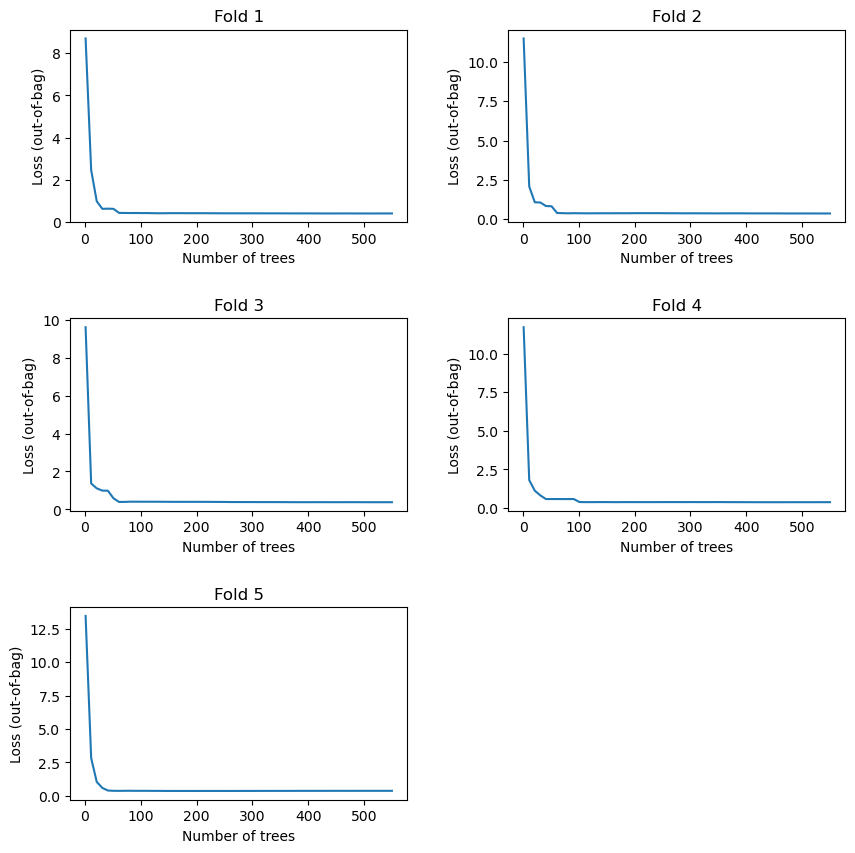

In [16]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

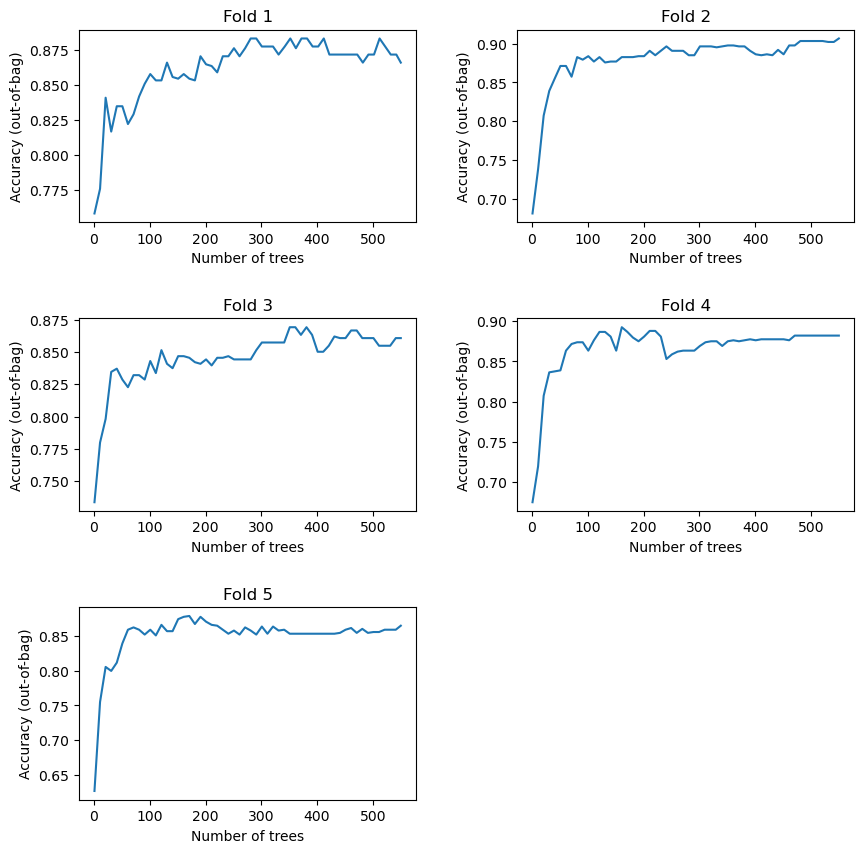

In [17]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Accuracy (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

In the initial plots, we can observe how the loss decreases and approaches zero as the number of trees increases. In the subsequent plots, we see how the accuracy changes as the number of trees increases. By examining these plots, we can see that even with an increasing number of trees, our scores for both loss and accuracy would not improve significantly. That is why we decided to stick with 550 trees with a depth of 6. 

In the first set of graphs, we can observe a gradual decrease in the loss value as the number of trees increases. These loss values tend towards zero, indicating an improvement in the model's ability to fit the data.

In the following graphs, we see how the accuracy value changes as the number of trees increases. It is noticeable that as the number of trees increases, the accuracy also increases, indicating better performance of the model.

However, by examining these graphs, we can see that increasing the number of trees does not necessarily lead to a significant improvement in the loss and accuracy scores. Beyond a certain point, the benefit of adding more trees becomes marginal and does not justify the increase in complexity and computational cost.

That is why the decision was made to stick with `550` trees and a depth of `6` since it was considered that these values offer a suitable balance between performance and computational efficiency, without significantly compromising the achieved loss and accuracy scores.

We can also see some general stats on the OOB dataset:

In [18]:
for _model in models:
    inspector = models[_model].make_inspector()
    print("*"*80)
    print(_model, inspector.evaluation())

********************************************************************************
fold_1 Evaluation(num_examples=493, accuracy=0.8657528687111298, loss=0.39946834217178023, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
********************************************************************************
fold_2 Evaluation(num_examples=493, accuracy=0.9065865170858219, loss=0.3661344547861831, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
********************************************************************************
fold_3 Evaluation(num_examples=494, accuracy=0.860904312570069, loss=0.3798962228316164, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
********************************************************************************
fold_4 Evaluation(num_examples=494, accuracy=0.8821551504777397, loss=0.38469492520783366, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
********************************************************************************
fold_5 Evaluat

Now, let us check the evaluation metrics for each fold and its average value.

In [19]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print("\n")
print("*"*80)
print(f"Average accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")
print("*"*80)

fold_1: acc: 0.9677 loss: 0.2300
fold_2: acc: 0.8790 loss: 0.2759
fold_3: acc: 0.9106 loss: 0.2910
fold_4: acc: 0.9268 loss: 0.2827
fold_5: acc: 0.9512 loss: 0.2435


********************************************************************************
Average accuracy: 0.9271  Average loss: 0.2646
********************************************************************************


The model performs very well despite the small amount of data available. By adjusting the number of trees and their depth, we were able to achieve an average precision of nearly 93% and a loss of approximately 26%. These results are highly encouraging and demonstrate the effectiveness of the model despite the limitations in the amount of data used.

## Submission

In [20]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
predictions = models['fold_1'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

1/1 [==============================] - 0s 97ms/step
[[0.64727303, 0.35272697], [0.64727303, 0.35272697], [0.64727303, 0.35272697], [0.64727303, 0.35272697], [0.64727303, 0.35272697]]


In [21]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)

In [22]:
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.647273,0.352727
1,010ebe33f668,0.647273,0.352727
2,02fa521e1838,0.647273,0.352727
3,040e15f562a2,0.647273,0.352727
4,046e85c7cc7f,0.647273,0.352727
